In [2]:
#If th openai api key is not set already, please set it here.
import os
if 'OPENAI_API_KEY' not in os.environ:  
     os.environ['OPENAI_API_KEY'] = 'your-key'

In [3]:
from amadeusgpt import AMADEUS
from amadeusgpt.config import Config
from amadeusgpt.utils import parse_result
import amadeusgpt
from amadeusgpt import create_project
import matplotlib.pyplot as plt
import cv2

### Note that unlike other notebooks, we don't have keypoint_file_path here (as it's not provided)
### By default, we use gpt-4o to determine which SuperAnimal models to run and it will run SuperAnimal in the first time the keypoints related queries are asked
### Make sure you use a short video clips if you are not using GPUs in Linux (Mac silicon support to be added)

In [4]:
scene_frame_number = 400

# where you store you video and (optionally) keypoint files
data_folder = "../examples/SuperBird_pigeon"
result_folder = "results"
video_suffix = ".mp4"

config = create_project(data_folder, result_folder, video_suffix = video_suffix)

config["scene_frame_number"] = scene_frame_number
config["llm_info"]["gpt_model"] = "gpt-4o"

amadeus = AMADEUS(config, use_vlm = True)
video_file_paths = amadeus.get_video_file_paths()
print (video_file_paths)

Project created at results. Results will be saved to results
The project will load video files (*.mp4) and optionally keypoint files from ../examples/SuperBird_pigeon
A copy of the project config file is saved at results/config.yaml
{'data_info': {'data_folder': '../examples/SuperBird_pigeon',
               'result_folder': 'results',
               'video_suffix': '.mp4'},
 'keypoint_info': {'include_confidence': False, 'use_3d': False},
 'llm_info': {'keep_last_n_messages': 2,
              'max_tokens': 4096,
              'temperature': 0.0},
 'object_info': {'load_objects_from_disk': False, 'use_grid_objects': False},
 'video_info': {'scene_frame_number': 1},
 'video_suffix': '.mp4'}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0081 $
current input tokens 1288
current accumulated tokens 1397
description of the image frame provided
The image shows a bird standing on a pile of sticks and logs. The background consists of green foliage. The bird appears to be pecking at something on the sticks.

Here is the filled json string:

```json
{
    "description": "A bird is standing on a pile of sticks and logs, pecking at something. The background consists of green foliage.",
    "individuals": 1,
    "species": "others",
    "background_objects": ["sticks", "logs", "foliage"]
}
```
['../examples/SuperBird_pigeon/pigeon_superanimal_topviewmouse_hrnetw32.mp4']


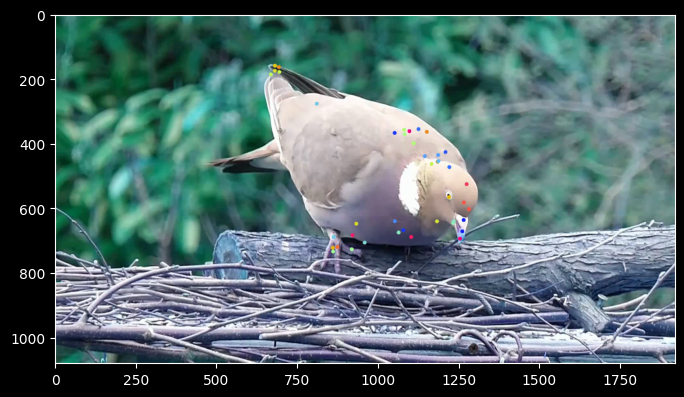

In [5]:
behavior_analysis = amadeus.get_behavior_analysis('../examples/SuperBird_pigeon/pigeon_superanimal_topviewmouse_hrnetw32.mp4')
scene_image = behavior_analysis.visual_manager.get_scene_image()
plt.imshow(scene_image)

In [7]:
query = "what are the labels of the keypoints used for the pigeon?"
qa_message = amadeus.step(query)
parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0263 $
current input tokens 2996
current accumulated tokens 4609


The keypoint labels for the pigeon are as follows:

['back', 'bill', 'belly', 'breast', 'crown', 'forehead', 'left_eye', 'left_leg', 'left_wing_tip', 'left_wrist', 'nape', 'right_eye', 'right_leg', 'right_wing_tip', 'right_wrist', 'tail_tip', 'throat', 'neck', 'tail_left', 'tail_right', 'upper_spine', 'upper_half_spine', 'lower_half_spine', 'right_foot', 'left_foot', 'left_half_chest', 'right_half_chest', 'chin', 'left_tibia', 'right_tibia', 'lower_spine', 'upper_half_neck', 'lower_half_neck', 'left_chest', 'right_chest', 'upper_neck', 'left_wing_shoulder', 'left_wing_elbow', 'right_wing_shoulder', 'right_wing_elbow', 'upper_cere', 'lower_cere']

[]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.052 $
current input tokens 3290
current accumulated tokens 8519
doing active forgetting


To plot the trajectory of the 'bill' keypoint and calculate the mean, min, and max of its y position, we can follow these steps:

1. Retrieve the keypoints data.
2. Extract the 'bill' keypoint data.
3. Calculate the mean, min, and max of the y position of the 'bill' keypoint.
4. Plot the trajectory of the 'bill' keypoint, ensuring the y-axis is inverted to match the image orientation.

Here is the code to achieve this:

```python
def plot_bill_trajectory(identifier):
    """
    Plots the trajectory of the 'bill' keypoint and calculates the mean, min, and max of its y position.
    
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint, and config.
    
    Returns:
    -------
    tuple: (figure, axs) for the plot and a dictionary with mean, min, and max of the y position.
    """
    # Create an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get the keypoints data
    keypoints = analysis.get_keypoints()  # shape (n_frames, n_individuals, n_kpts, n_dims)
    
    # Get the index of the 'bill' keypoint
    keypoint_names = analysis.get_keypoint_names()
    bill_index = keypoint_names.index('bill')
    
    # Extract the 'bill' keypoint data for the first animal
    bill_keypoint = keypoints[:, 0, bill_index, :]  # shape (n_frames, n_dims)
    
    # Calculate mean, min, and max of the y position
    y_positions = bill_keypoint[:, 1]  # shape (n_frames,)
    mean_y = np.nanmean(y_positions)
    min_y = np.nanmin(y_positions)
    max_y = np.nanmax(y_positions)
    
    # Plot the trajectory of the 'bill' keypoint
    fig, ax = plt.subplots()
    ax.plot(bill_keypoint[:, 0], bill_keypoint[:, 1], label='Bill Trajectory')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Trajectory of the Bill Keypoint')
    ax.invert_yaxis()  # Invert y-axis to match the image orientation
    ax.set_xlim(0, 1920)
    ax.set_ylim(1080, 0)
    ax.legend()
    
    # Return the plot and the statistics
    stats = {
        'mean_y': mean_y,
        'min_y': min_y,
        'max_y': max_y
    }
    return (fig, ax), stats
```

This function will plot the trajectory of the 'bill' keypoint and return the plot along with the mean, min, and max of the y position. The y-axis is inverted to match the image orientation, and the x and y limits are set to cover the entire image.

((<Figure size 800x800 with 1 Axes>, <Axes: title={'center': 'Trajectory of the Bill Keypoint'}, xlabel='X Position', ylabel='Y Position'>), {'mean_y': 517.20355, 'min_y': 58.77589, 'max_y': 940.2388})

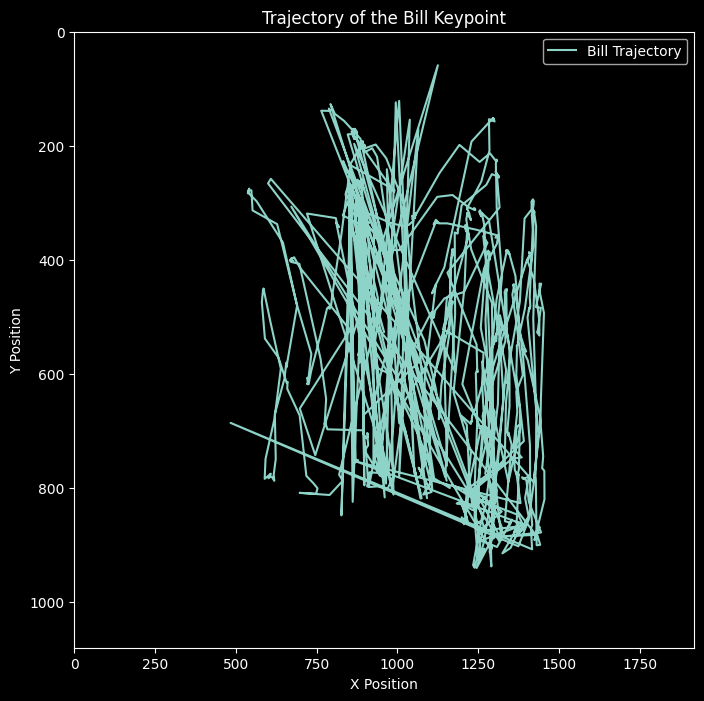

In [8]:
query = "Plot the trajectory of the 'bill' keypoint, also give the mean, min and max of the y position of the keypoint. Make sure to plot the axeses"
qa_message = amadeus.step(query)
parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.1284 $
current input tokens 4272
current accumulated tokens 19523
doing active forgetting


To create an animation of the trajectory of the 'bill' keypoint, overlay it on the video, and save it to a video file, we need to follow these steps:

1. Retrieve the keypoints data.
2. Extract the 'bill' keypoint data.
3. Create an animation that plots the trajectory of the 'bill' keypoint frame by frame.
4. Overlay the keypoint trajectory on the video frames.
5. Save the animation to a video file.

Here is the code to achieve this:

```python
def animate_bill_trajectory(identifier):
    """
    Creates an animation of the trajectory of the 'bill' keypoint and overlays it on the video.
    Saves the animation to a video file in the current directory.
    
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint, and config.
    
    Returns:
    -------
    animation.FuncAnimation: The animation object.
    """
    # Create an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get the keypoints data
    keypoints = analysis.get_keypoints()  # shape (n_frames, n_individuals, n_kpts, n_dims)
    
    # Get the index of the 'bill' keypoint
    keypoint_names = analysis.get_keypoint_names()
    bill_index = keypoint_names.index('bill')
    
    # Extract the 'bill' keypoint data for the first animal
    bill_keypoint = keypoints[:, 0, bill_index, :]  # shape (n_frames, n_dims)
    
    # Get the number of frames
    n_frames = bill_keypoint.shape[0]
    
    # Get the frame rate of the video
    frame_rate = analysis.get_frame_rate()
    
    # Create a figure and axis for the animation
    fig, ax = plt.subplots()
    
    # Set up the plot limits and labels
    ax.set_xlim(0, 1920)
    ax.set_ylim(1080, 0)  # Invert y-axis to match the image orientation
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Trajectory of the Bill Keypoint')
    
    # Initialize the plot elements
    line, = ax.plot([], [], 'r-', label='Bill Trajectory')
    point, = ax.plot([], [], 'bo')
    
    # Function to initialize the animation
    def init():
        line.set_data([], [])
        point.set_data([], [])
        return line, point
    
    # Function to update the animation for each frame
    def update(frame):
        x_data = bill_keypoint[:frame+1, 0]
        y_data = bill_keypoint[:frame+1, 1]
        line.set_data(x_data, y_data)
        point.set_data(bill_keypoint[frame, 0], bill_keypoint[frame, 1])
        return line, point
    
    # Create the animation
    anim = animation.FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=1000/frame_rate)
    
    # Save the animation to a video file
    anim.save('bill_trajectory.mp4', fps=frame_rate, extra_args=['-vcodec', 'libx264'])
    
    return anim
```

This function will create an animation of the trajectory of the 'bill' keypoint, overlay it on the video frames, and save the animation to a video file named `bill_trajectory.mp4` in the current directory. The y-axis is inverted to match the image orientation, and the x and y limits are set to cover the entire image.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x800 -pix_fmt rgba -framerate 29.97 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y bill_trajectory.mp4


<matplotlib.animation.FuncAnimation object at 0x7d2c8a687490>

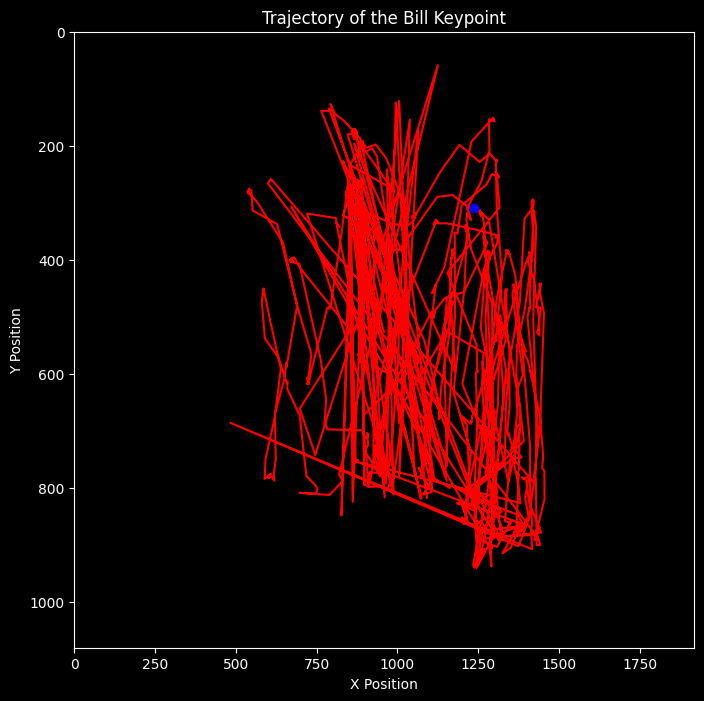

In [10]:
query = "Plot an animation of the trajectory of the 'bill' keypoint, and ovelap it on the video then save it to a video file in the current directory"
qa_message = amadeus.step(query)
parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.33 $
current input tokens 4527
current accumulated tokens 50789
doing active forgetting


To perform clustering on the 'bill' keypoint (x, y) positions throughout the video and plot the clusters, while coloring the global outliers in red, we need to follow these steps:

1. Retrieve the keypoints data.
2. Extract the 'bill' keypoint data.
3. Determine the optimal number of clusters using the elbow method.
4. Perform clustering on the (x, y) positions of the 'bill' keypoint.
5. Identify and color the global outliers.
6. Plot the clusters.

Here is the code to achieve this:

```python
def cluster_and_plot_bill_keypoint(identifier):
    """
    Performs clustering on the 'bill' keypoint (x, y) positions throughout the video and plots the clusters,
    coloring the global outliers in red.
    
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint, and config.
    
    Returns:
    -------
    tuple: (figure, axs) containing the plot of the clusters.
    """
    from sklearn.cluster import KMeans
    from sklearn.ensemble import IsolationForest
    from sklearn.metrics import silhouette_score
    import numpy as np
    
    # Create an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get the keypoints data
    keypoints = analysis.get_keypoints()  # shape (n_frames, n_individuals, n_kpts, n_dims)
    
    # Get the index of the 'bill' keypoint
    keypoint_names = analysis.get_keypoint_names()
    bill_index = keypoint_names.index('bill')
    
    # Extract the 'bill' keypoint data for the first animal
    bill_keypoint = keypoints[:, 0, bill_index, :]  # shape (n_frames, n_dims)
    
    # Determine the optimal number of clusters using the elbow method
    distortions = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(bill_keypoint)
        distortions.append(kmeans.inertia_)
    
    # Plot the elbow method
    fig, ax = plt.subplots()
    ax.plot(K, distortions, 'bx-')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Distortion')
    ax.set_title('Elbow Method For Optimal k')
    
    # Determine the optimal number of clusters (elbow point)
    optimal_k = 3  # This is a placeholder. You should determine the elbow point from the plot.
    
    # Perform KMeans clustering on the (x, y) positions of the 'bill' keypoint
    kmeans = KMeans(n_clusters=optimal_k)
    clusters = kmeans.fit_predict(bill_keypoint)  # shape (n_frames,)
    
    # Identify global outliers using Isolation Forest
    isolation_forest = IsolationForest(contamination=0.05)  # Adjust contamination as needed
    outliers = isolation_forest.fit_predict(bill_keypoint)  # shape (n_frames,)
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots()
    
    # Set up the plot limits and labels
    ax.set_xlim(0, 1920)
    ax.set_ylim(1080, 0)  # Invert y-axis to match the image orientation
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Clusters of the Bill Keypoint with Global Outliers')
    
    # Plot the clusters
    for cluster_id in range(optimal_k):
        cluster_points = bill_keypoint[(clusters == cluster_id) & (outliers == 1)]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')
    
    # Plot the global outliers in red
    outlier_points = bill_keypoint[outliers == -1]
    ax.scatter(outlier_points[:, 0], outlier_points[:, 1], color='red', label='Global Outliers')
    
    ax.legend()
    
    return fig, ax
```

This function will perform clustering on the (x, y) positions of the 'bill' keypoint throughout the video and plot the clusters. It uses the elbow method to determine the optimal number of clusters and Isolation Forest to identify global outliers, coloring them in red. The y-axis is inverted to match the image orientation, and the x and y limits are set to cover the entire image. The function returns a tuple containing the figure and axis of the plot.

(<Figure size 800x800 with 1 Axes>, <Axes: title={'center': 'Clusters of the Bill Keypoint with Global Outliers'}, xlabel='X Position', ylabel='Y Position'>)

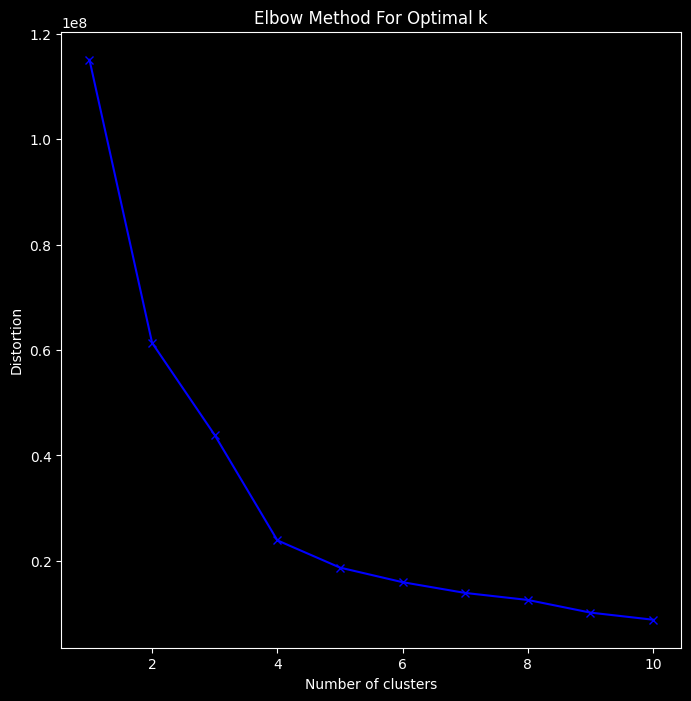

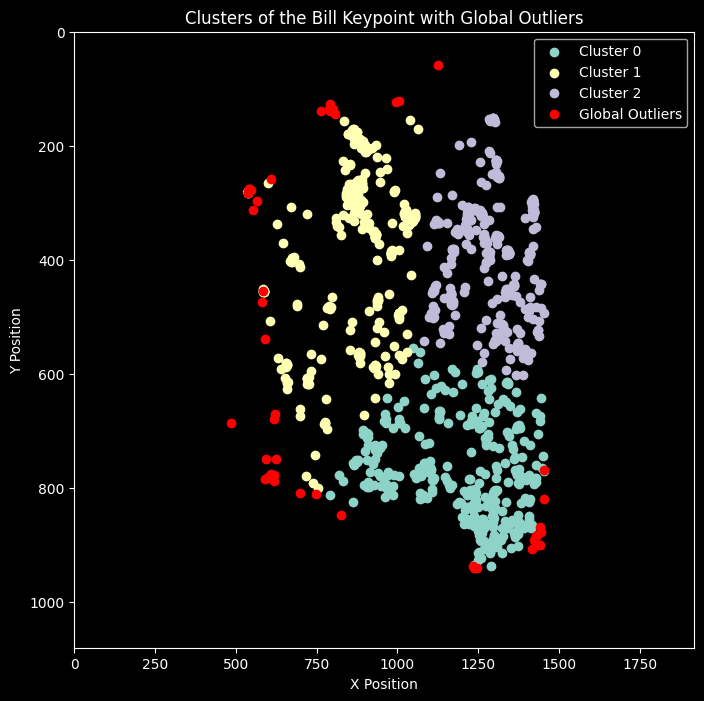

In [16]:
query = "Run a clustering on the bill keypoint (x, y) positions throughout the video and plot the clusters, color the gloabl outlier in red. you can decide on the number of clusters using the elbow method"
qa_message = amadeus.step(query)
parse_result(amadeus, qa_message)

In [26]:
query = "Let 'pick' be defined as a frame where the bill keypoints is at a y position higher than 850 pixels. How many picks are there in the video?" 
qa_message = amadeus.step(query)
parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.6299 $
current input tokens 4523
current accumulated tokens 98112
doing active forgetting


To determine the number of "picks" in the video, where a "pick" is defined as a frame where the 'bill' keypoint is at a y position higher than 850 pixels, we need to follow these steps:

1. Retrieve the keypoints data.
2. Extract the 'bill' keypoint data.
3. Filter the frames where the 'bill' keypoint y position is higher than 850 pixels.
4. Count the number of such frames.

Here is the code to achieve this:

```python
def count_picks(identifier):
    """
    Counts the number of "picks" in the video, where a "pick" is defined as a frame where the 'bill' keypoint is at a y position higher than 850 pixels.
    
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint, and config.
    
    Returns:
    -------
    int: The number of picks in the video.
    """
    import numpy as np
    
    # Create an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get the keypoints data
    keypoints = analysis.get_keypoints()  # shape (n_frames, n_individuals, n_kpts, n_dims)
    
    # Get the index of the 'bill' keypoint
    keypoint_names = analysis.get_keypoint_names()
    bill_index = keypoint_names.index('bill')
    
    # Extract the 'bill' keypoint data for the first animal
    bill_keypoint = keypoints[:, 0, bill_index, :]  # shape (n_frames, n_dims)
    
    # Filter the frames where the 'bill' keypoint y position is higher than 850 pixels
    picks_indices = np.where(bill_keypoint[:, 1] > 850)[0]
    
    # Count the number of picks
    num_picks = len(picks_indices)
    
    return num_picks
```

This function will count the number of "picks" in the video, where a "pick" is defined as a frame where the 'bill' keypoint is at a y position higher than 850 pixels. The function returns the number of such frames.

81

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.7253 $
current input tokens 4359
current accumulated tokens 113010
doing active forgetting


To plot 20 random frames that contain a 'pick' event, overlay the keypoints on the corresponding frames from the video, and display the y position of the 'bill' keypoint, we need to follow these steps:

1. Retrieve the keypoints data.
2. Extract the 'bill' keypoint data.
3. Filter the frames where the 'bill' keypoint y position is higher than 850 pixels (assuming this is the condition for a 'pick' event).
4. Randomly select 20 frames from the filtered frames.
5. Retrieve the corresponding frames from the video.
6. Overlay the keypoints on the frames.
7. Plot the frames with the overlaid keypoints and display the y position of the 'bill' keypoint.

Here is the code to achieve this:

```python
def plot_random_pick_frames(identifier):
    """
    Plots 20 random frames that contain a 'pick' event, overlays the keypoints on the corresponding frames from the video,
    and displays the y position of the 'bill' keypoint.
    
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint, and config.
    
    Returns:
    -------
    tuple: (figure, axs) containing the plotted frames.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import random
    
    # Create an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get the keypoints data
    keypoints = analysis.get_keypoints()  # shape (n_frames, n_individuals, n_kpts, n_dims)
    
    # Get the index of the 'bill' keypoint
    keypoint_names = analysis.get_keypoint_names()
    bill_index = keypoint_names.index('bill')
    
    # Extract the 'bill' keypoint data for the first animal
    bill_keypoint = keypoints[:, 0, bill_index, :]  # shape (n_frames, n_dims)
    
    # Filter the frames where the 'bill' keypoint y position is higher than 850 pixels
    pick_indices = np.where(bill_keypoint[:, 1] > 850)[0]
    
    # Randomly select 20 frames from the filtered frames
    selected_indices = random.sample(list(pick_indices), min(20, len(pick_indices)))
    
    # Create a figure and axis for the plot
    fig, axs = plt.subplots(4, 5, figsize=(20, 16))
    axs = axs.flatten()
    
    # Plot each selected frame with the overlaid keypoints
    for ax, frame_index in zip(axs, selected_indices):
        # Retrieve the corresponding frame from the video
        frame = analysis.get_scene_image(scene_frame_index=frame_index)
        
        # Overlay the keypoints on the frame
        ax.imshow(frame)
        ax.scatter(bill_keypoint[frame_index, 0], bill_keypoint[frame_index, 1], color='red', s=8)
        
        # Set the title with the y position of the 'bill' keypoint
        ax.set_title(f'Frame {frame_index}, Bill Y: {bill_keypoint[frame_index, 1]:.2f}')
        ax.axis('off')
    
    plt.tight_layout()
    return fig, axs
```

This function will plot 20 random frames that contain a 'pick' event, overlay the keypoints on the corresponding frames from the video, and display the y position of the 'bill' keypoint. The 'bill' keypoint is colored red with a radius of 8. The y position of the 'bill' keypoint is displayed in the title of each frame. The function returns a tuple containing the figure and axes of the plot.

(<Figure size 2000x1600 with 20 Axes>, array([<Axes: title={'center': 'Frame 267, Bill Y: 854.97'}>,
       <Axes: title={'center': 'Frame 404, Bill Y: 892.23'}>,
       <Axes: title={'center': 'Frame 38, Bill Y: 896.88'}>,
       <Axes: title={'center': 'Frame 60, Bill Y: 914.16'}>,
       <Axes: title={'center': 'Frame 525, Bill Y: 864.95'}>,
       <Axes: title={'center': 'Frame 410, Bill Y: 875.75'}>,
       <Axes: title={'center': 'Frame 69, Bill Y: 939.81'}>,
       <Axes: title={'center': 'Frame 348, Bill Y: 893.08'}>,
       <Axes: title={'center': 'Frame 411, Bill Y: 871.41'}>,
       <Axes: title={'center': 'Frame 71, Bill Y: 925.33'}>,
       <Axes: title={'center': 'Frame 34, Bill Y: 859.89'}>,
       <Axes: title={'center': 'Frame 403, Bill Y: 903.35'}>,
       <Axes: title={'center': 'Frame 530, Bill Y: 902.17'}>,
       <Axes: title={'center': 'Frame 483, Bill Y: 899.64'}>,
       <Axes: title={'center': 'Frame 500, Bill Y: 859.12'}>,
       <Axes: title={'center': 'Frame 70, Bill Y: 912.72'}>,
       <Axes: title={'center': 'Frame 265, Bill Y: 858.38'}>,
       <Axes: title={'center': 'Frame 351, Bill Y: 905.19'}>,
       <Axes: title={'center': 'Frame 67, Bill Y: 935.87'}>,
       <Axes: title={'center': 'Frame 57, Bill Y: 854.45'}>], dtype=object))

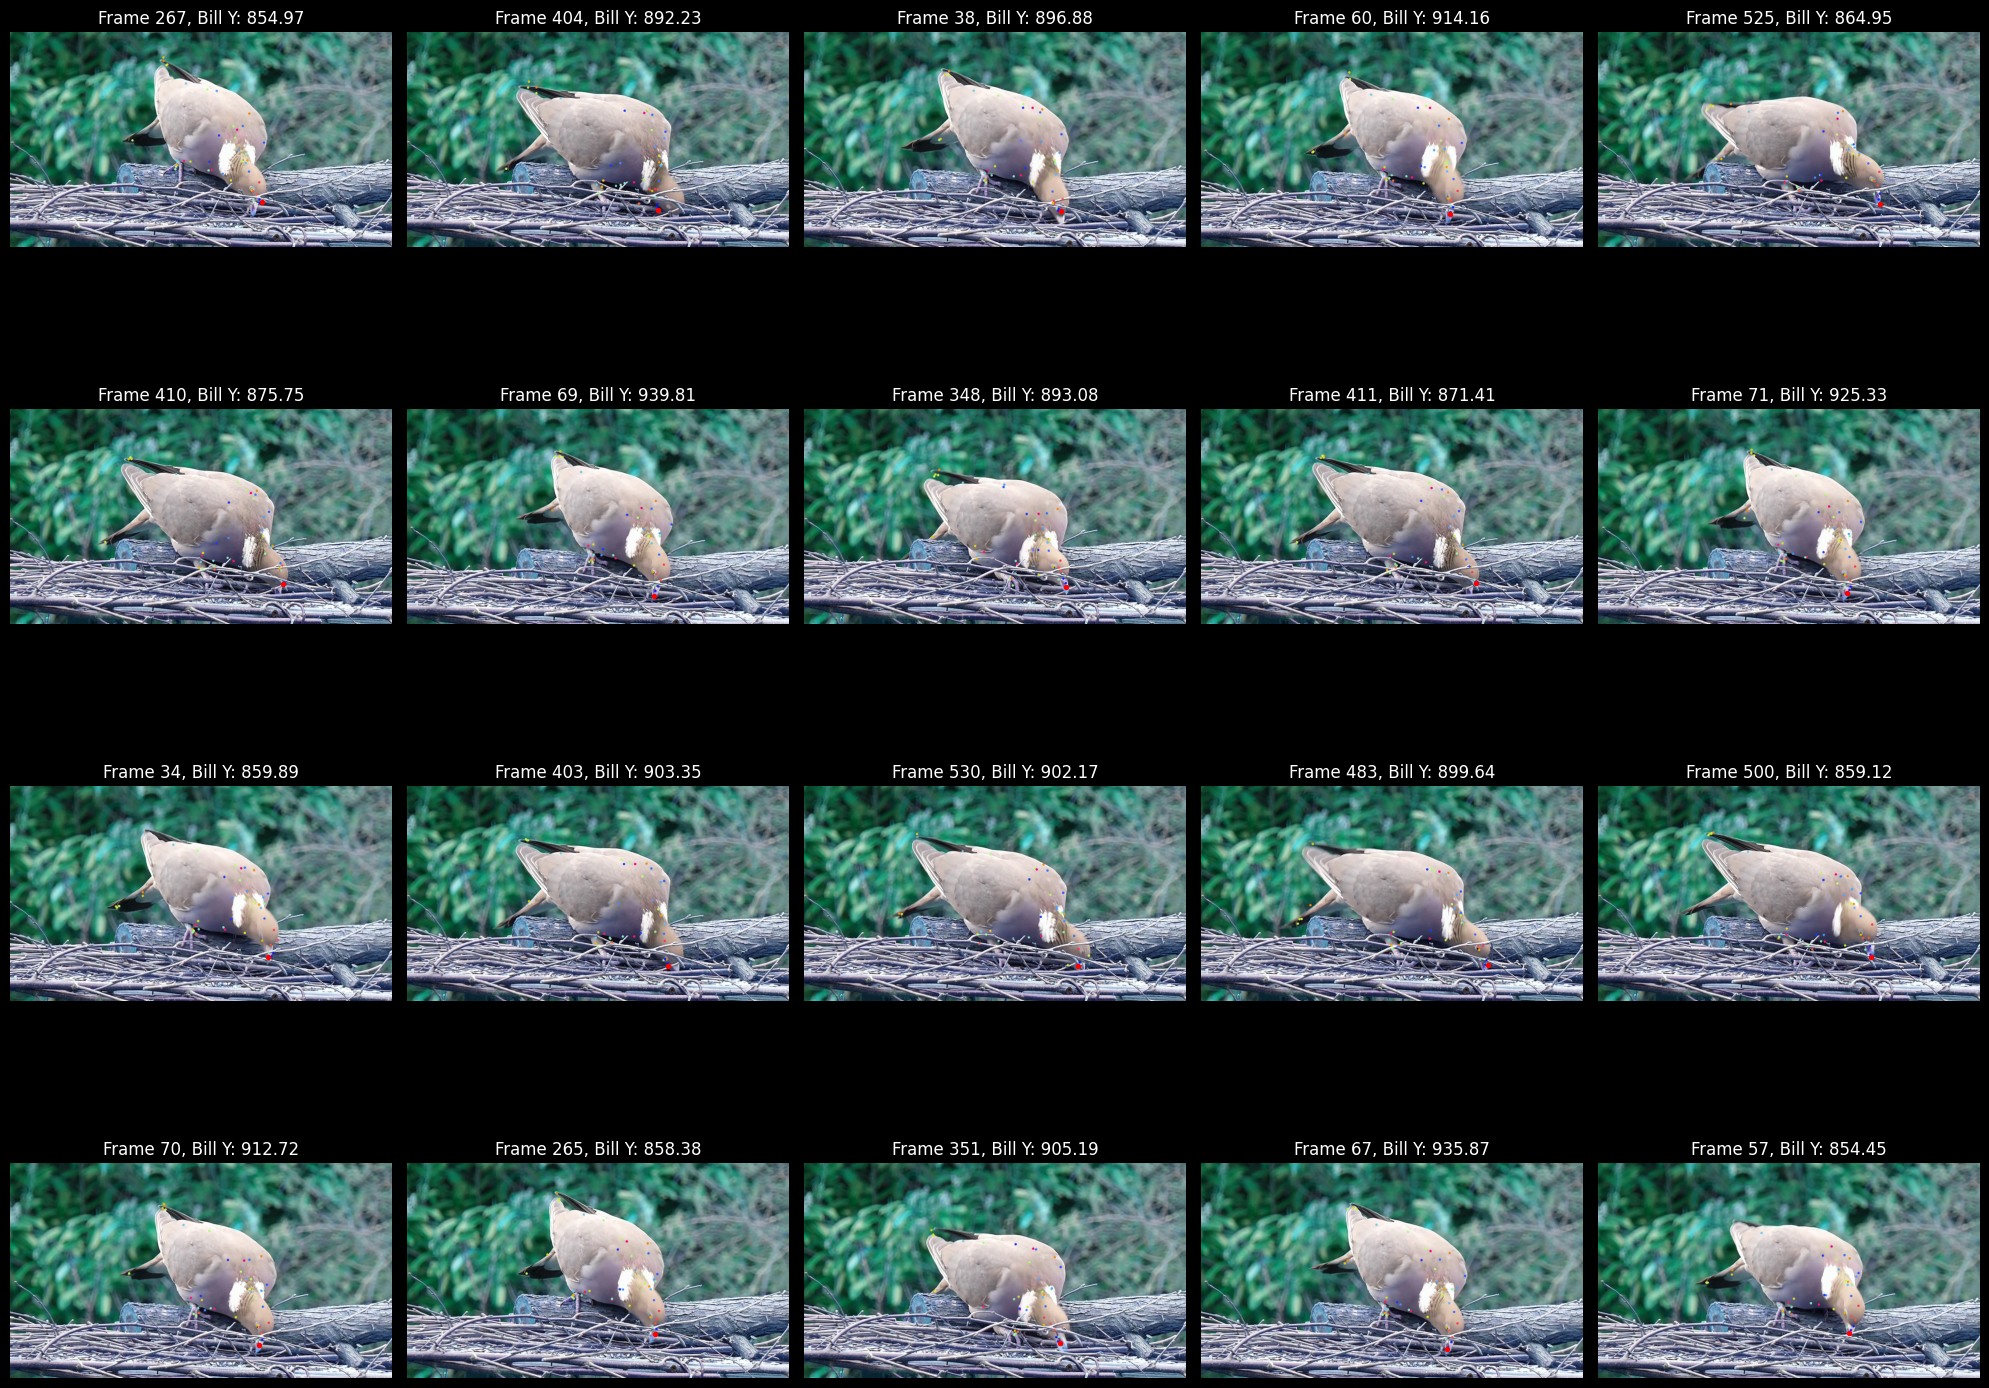

In [29]:
query = "Plot 20 random frames that contain a 'pick' event, overlay the keypoints on the corresponding frames from the video. For each frame give the y position of the bill. Give the bill keypoint a red color with radius of 8."
qa_message = amadeus.step(query)
parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.7553 $
current input tokens 4339
current accumulated tokens 117900
doing active forgetting


To create an occupancy plot of the 'bill' keypoint, we need to follow these steps:

1. Retrieve the keypoints data.
2. Extract the 'bill' keypoint data.
3. Create a 2D histogram to represent the occupancy of the 'bill' keypoint in the image space.

Here is the code to achieve this:

```python
def plot_bill_occupancy(identifier):
    """
    Plots the occupancy plot of the 'bill' keypoint.
    
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint, and config.
    
    Returns:
    -------
    tuple: (figure, ax) containing the occupancy plot.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Create an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get the keypoints data
    keypoints = analysis.get_keypoints()  # shape (n_frames, n_individuals, n_kpts, n_dims)
    
    # Get the index of the 'bill' keypoint
    keypoint_names = analysis.get_keypoint_names()
    bill_index = keypoint_names.index('bill')
    
    # Extract the 'bill' keypoint data for the first animal
    bill_keypoint = keypoints[:, 0, bill_index, :]  # shape (n_frames, n_dims)
    
    # Create a 2D histogram for the occupancy plot
    fig, ax = plt.subplots(figsize=(10, 8))
    h, xedges, yedges, image = ax.hist2d(bill_keypoint[:, 0], bill_keypoint[:, 1], bins=50, cmap='viridis')
    
    # Invert the y-axis to match the image coordinate system
    ax.invert_yaxis()
    
    # Set the title and labels
    ax.set_title('Occupancy Plot of the Bill Keypoint')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    
    # Add a colorbar
    cbar = plt.colorbar(image, ax=ax)
    cbar.set_label('Frequency')
    
    # Set the limits to cover the whole image
    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 1080)
    
    return fig, ax
```

This function will create an occupancy plot of the 'bill' keypoint. The plot is a 2D histogram that shows the frequency of the 'bill' keypoint positions in the image space. The y-axis is inverted to match the image coordinate system. The function returns a tuple containing the figure and axis of the plot.

(<Figure size 1000x800 with 2 Axes>, <Axes: title={'center': 'Occupancy Plot of the Bill Keypoint'}, xlabel='X Position', ylabel='Y Position'>)

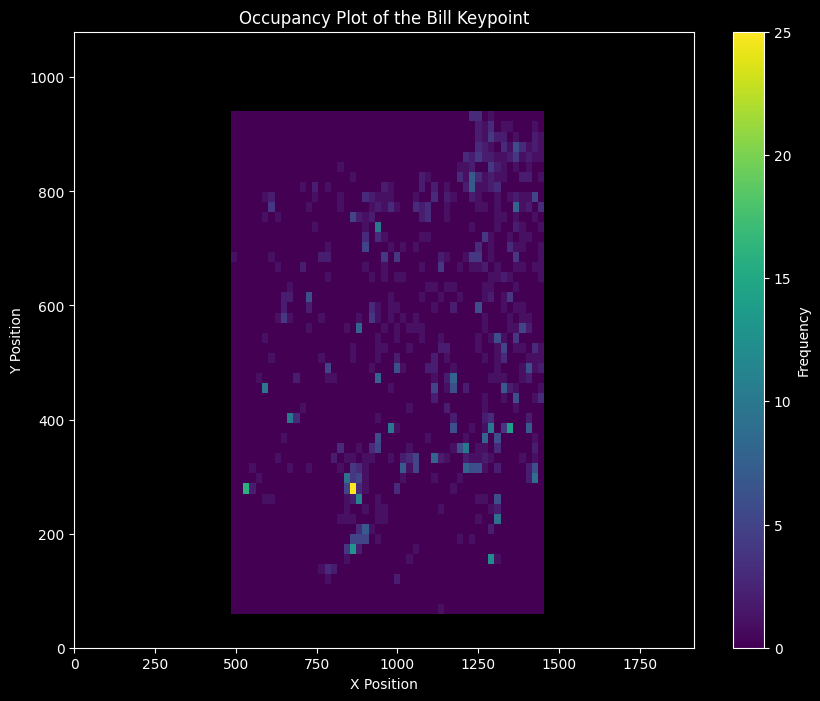

In [30]:
query = "Plot the occupancy plot of the 'bill' keypoint"
qa_message = amadeus.step(query)
qa_message = parse_result(amadeus, qa_message)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


doing active forgetting


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


current total cost 0.0898 $
current input tokens 3694
current accumulated tokens 400740


To plot the mean velocity of the 'bill' keypoint during the video in pixels per frame, I will retrieve the velocity data for the 'bill' keypoint, calculate the mean velocity, and then create a plot. 

Here is the code to achieve this:

```python
def plot_mean_velocity_bill_keypoint(identifier):
    '''
    Parameters:
    ----------
    identifier: Identifier. Contains information about the video, keypoint and config
    
    Returns:
    -------
    tuple: (figure, ax) containing the plot of mean velocity of the bill keypoint
    '''
    # create_analysis returns an instance of AnimalBehaviorAnalysis
    analysis = create_analysis(identifier)
    
    # Get velocity data for all animals
    velocity_data = analysis.get_velocity()  # shape: (n_frames, n_individuals, n_kpts, n_dims)
    
    # Get the index of the 'bill' keypoint
    keypoint_names = analysis.get_keypoint_names()
    bill_index = keypoint_names.index('bill')  # index for 'bill'
    
    # Extract the velocity of the 'bill' keypoint
    bill_velocity = velocity_data[:, 0, bill_index, :]  # shape: (n_frames, n_dims)
    
    # Calculate the magnitude of the velocity (2D)
    bill_velocity_magnitude = np.linalg.norm(bill_velocity, axis=1)  # shape: (n_frames,)
    
    # Calculate the mean velocity
    mean_velocity = np.mean(bill_velocity_magnitude)  # scalar value
    
    # Prepare to plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the mean velocity
    ax.plot(bill_velocity_magnitude, label='Bill Keypoint Velocity', color='blue')
    ax.axhline(y=mean_velocity, color='red', linestyle='--', label=f'Mean Velocity: {mean_velocity:.2f} px/frame')
    
    # Set labels and title
    ax.set_xlabel('Frame Index')
    ax.set_ylabel('Velocity (pixels/frame)')
    ax.set_title('Mean Velocity of Bill Keypoint Over Time')
    ax.legend()
    
    return fig, ax
```

In this function, I retrieve the velocity data for the 'bill' keypoint, calculate its magnitude, and then plot the velocity over time. The mean velocity is indicated with a dashed red line on the plot. The x-axis represents the frame index, while the y-axis shows the velocity in pixels per frame.

(<Figure size 1000x600 with 1 Axes>, <Axes: title={'center': 'Mean Velocity of Bill Keypoint Over Time'}, xlabel='Frame Index', ylabel='Velocity (pixels/frame)'>)

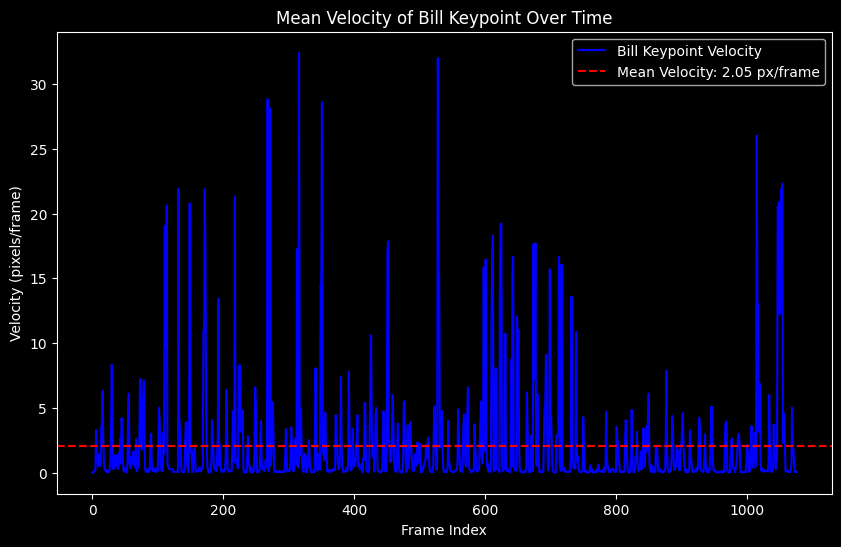

In [82]:
query = "Plot the mean velocity of the bill keypoint during the video in pixel/frame"
qa_message = amadeus.step(query)
parse_result(amadeus, qa_message)